# Evironment initialization

In [1]:
source("./initialization.r")

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: DT
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: magick
Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading re

# Data inspection

In [2]:
bugsData <- read.table("bugs.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [3]:
classes <- sapply(bugsData, class)
classes
dim(bugsData)
dim(na.omit(bugsData))

CBO                 DIT               FanIn              FanOut 
          "integer"           "integer"           "integer"           "integer" 
               LCOM                 NOC                 RFC                 WMC 
          "integer"           "integer"           "integer"           "integer" 
                LOC          Attributes AttributesInherited             Methods 
          "integer"           "integer"           "integer"           "integer" 
   MethodsInherited                Bugs 
          "integer"           "integer"

[1] 997  14

[1] 997  14

In [4]:
summary(bugsData)

      CBO              DIT            FanIn             FanOut      
 Min.   :  0.00   Min.   :1.000   Min.   :  0.000   Min.   : 0.000  
 1st Qu.:  3.00   1st Qu.:1.000   1st Qu.:  1.000   1st Qu.: 2.000  
 Median :  7.00   Median :2.000   Median :  2.000   Median : 4.000  
 Mean   : 12.22   Mean   :2.727   Mean   :  5.368   Mean   : 7.395  
 3rd Qu.: 14.00   3rd Qu.:4.000   3rd Qu.:  4.000   3rd Qu.:10.000  
 Max.   :156.00   Max.   :8.000   Max.   :137.000   Max.   :93.000  
      LCOM              NOC               RFC               WMC         
 Min.   :    0.0   Min.   : 0.0000   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:    6.0   1st Qu.: 0.0000   1st Qu.:  12.00   1st Qu.:   8.00  
 Median :   28.0   Median : 0.0000   Median :  30.00   Median :  20.00  
 Mean   :  364.7   Mean   : 0.7121   Mean   :  76.87   Mean   :  58.38  
 3rd Qu.:   91.0   3rd Qu.: 0.0000   3rd Qu.:  70.00   3rd Qu.:  50.00  
 Max.   :81003.0   Max.   :26.0000   Max.   :2603.00   Max.   :1680.00  
      

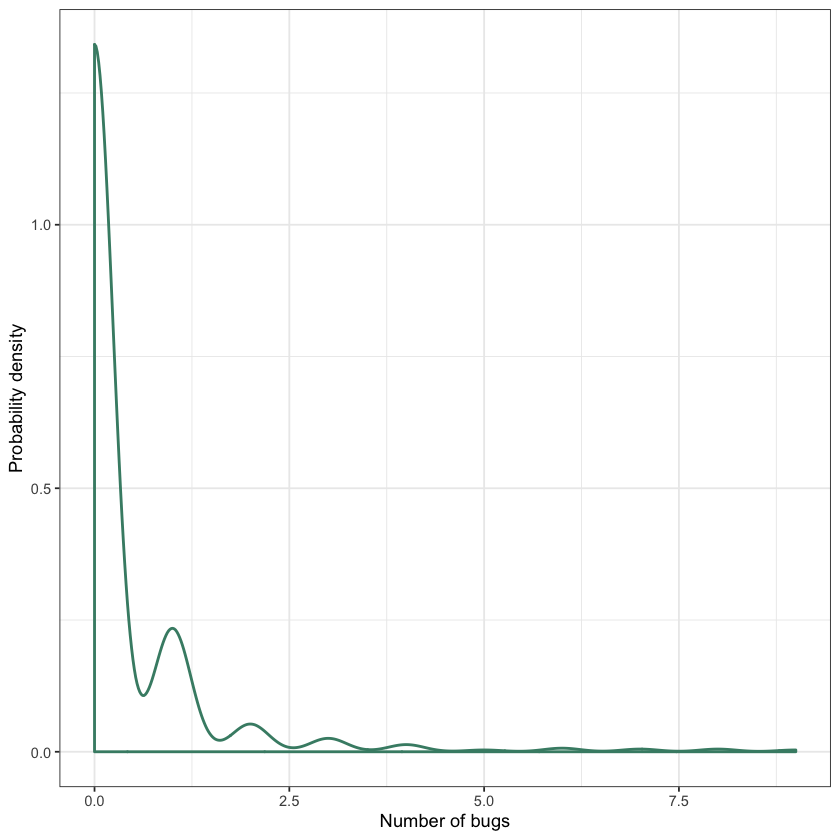

In [5]:
 ggplot(data=bugsData, aes(x=Bugs)) +
  geom_density(color = "aquamarine4", lwd = 0.8) +
  labs(x = "Number of bugs", y = "Probability density") +
  theme_bw()

# Statistical analysis
Correletion "matrix"

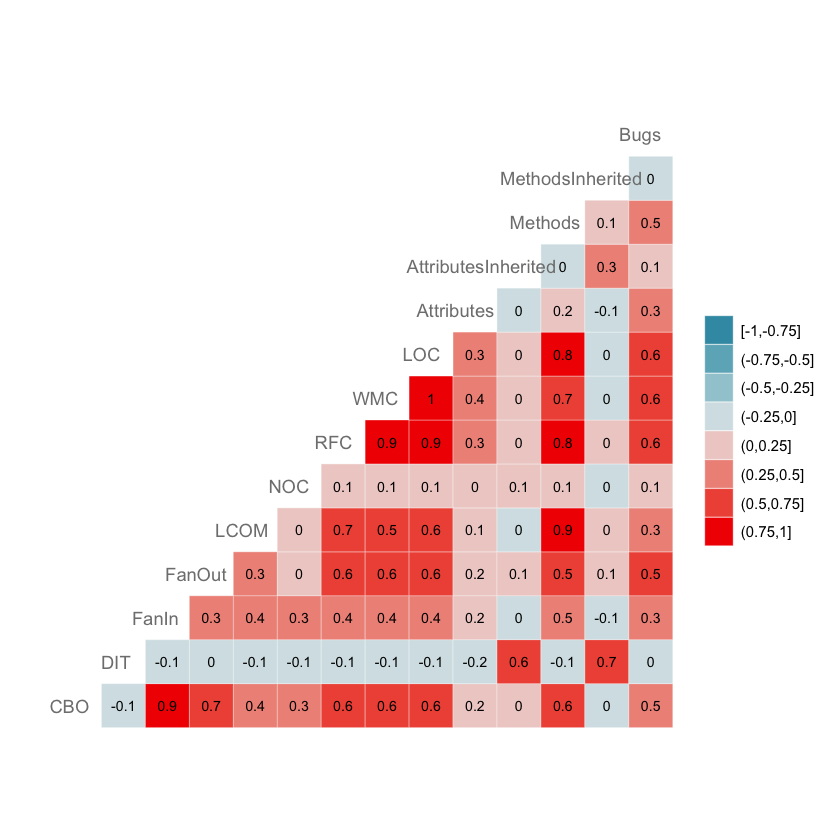

In [6]:
ggcorr(
    bugsData,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

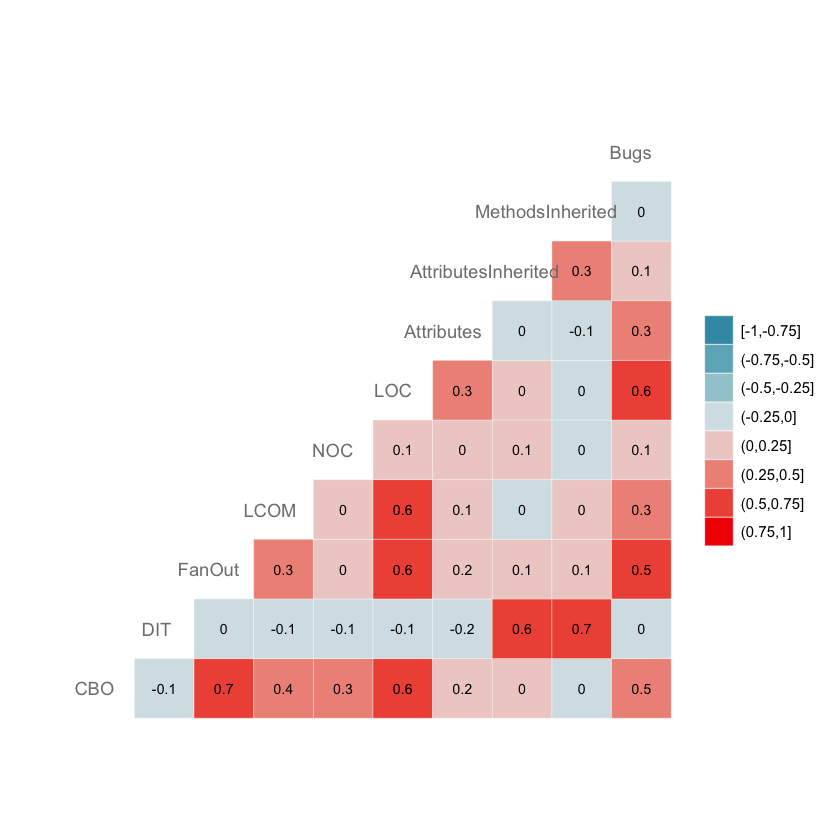

In [7]:
bugsDataWoCor <- subset(bugsData, select = -c(Methods, FanIn, WMC, RFC))
ggcorr(
    bugsDataWoCor,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

## Data distribution plotted
Don't know how to interpret this...

In [13]:
numericChart <- function(colName, colorCol) {
  ggplot(bugsData, aes(x = Bugs, y = bugsDataWoCor[[colName]])) +
    geom_jitter(size = 1.5, stat = "identity", colour=colorCol) +
    labs(x = "Bugs", y = colName) +
    theme_bw()
}

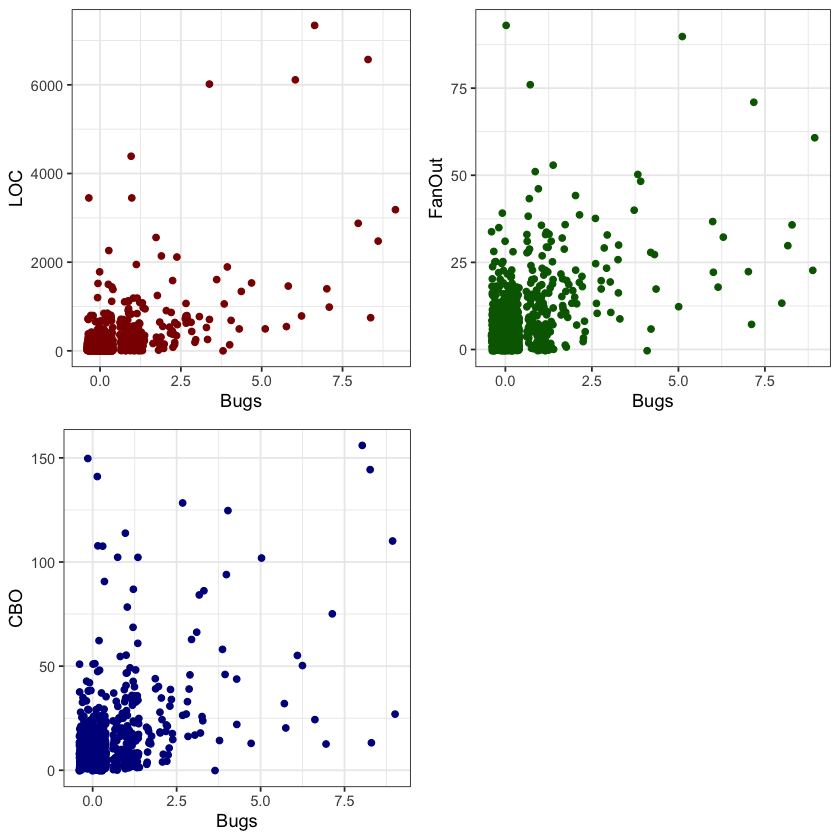

In [79]:
plot_grid(
  numericChart("LOC", "darkred"),
    numericChart("FanOut", "darkgreen"),
    numericChart("CBO", "darkblue")
)

# Prepare prediction environment

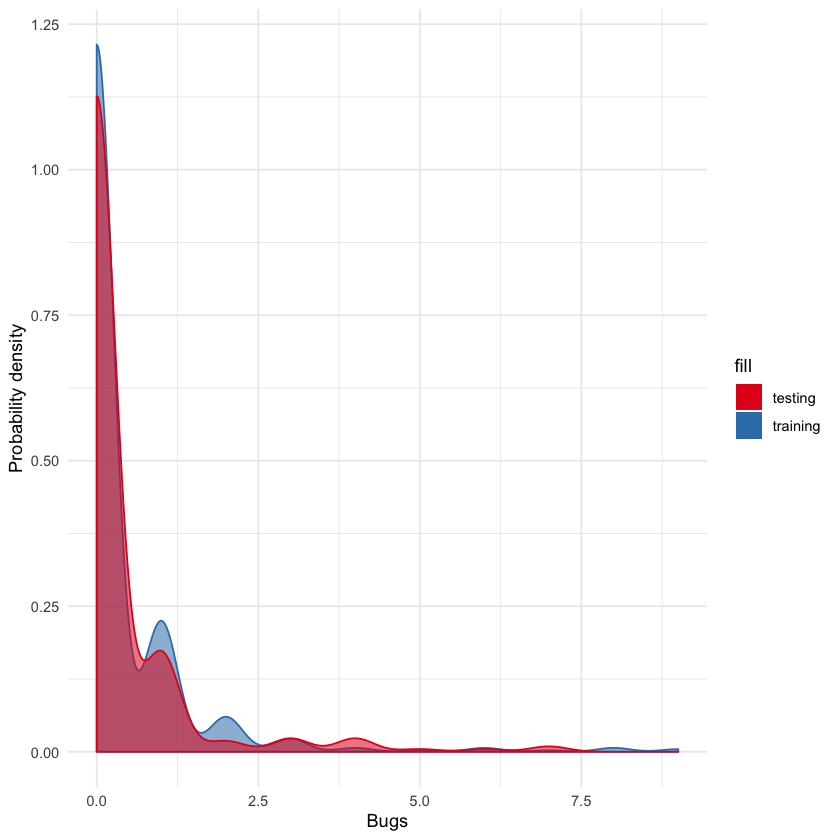

In [80]:
inTrain <- createDataPartition(bugsDataWoCor$Bugs, p=0.7, list=FALSE)
training <- bugsDataWoCor[inTrain,]
testing <- bugsDataWoCor[-inTrain,]

ggplot(mapping=aes(alpha=0.2)) + 
 geom_density(aes(Bugs, fill="training", color="training"), training) + 
 geom_density(aes(Bugs, fill="testing", color="testing"), testing) + 
 theme_minimal() +
  xlab("Bugs") +
  ylab("Probability density") +
  scale_fill_brewer(palette="Set1") +
  scale_color_brewer(palette="Set1") + 
  guides(color = FALSE, alpha = FALSE, fill=guide_legend(override.aes = list(color = NA)))

In [50]:
X_train = select(training, -Bugs)
y_train = training$Bugs
X_test = select(testing, -Bugs)
y_test = testing$Bugs

In [51]:
trcontrol = trainControl(
  method = "cv",
  number = 10,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

In [52]:
evaluateStats <- function(model) {
  predicted = predict(model, X_test)
  residuals = y_test - predicted
  
  RMSE <- round(sqrt(mean(residuals^2)), 3)
  
  y_testMean = mean(y_test)
  totalSS =  sum((y_test - y_testMean)^2 )
  residualSS =  sum(residuals^2)
  rSquare  =  round(1 - (residualSS/totalSS), 3)
  
  list(RMSE = RMSE, rSquare = rSquare)
}

In [53]:
predictionChart <- function(model) {
  predicted = predict(model, X_test)
  mergedResults = as.data.frame(cbind(predicted = predicted, observed = y_test))
  # Plot predictions vs test data
  ggplot(mergedResults, aes(y = predicted, x = observed)) +
    geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm) +
    ylab("Predicted number of bugs") +
    xlab("Real number of bugs") + 
    theme(
      axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
      axis.title.x = element_text(size=14), axis.title.y = element_text(size=14)
    )
}

In [54]:
importancePlot <- function(model) ggplot(varImp(model))

# kNN without Preprocessing

In [55]:
knnGrid <- expand.grid(k = seq(1, 25, by = 2))

In [56]:
knnModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid
)

In [57]:
knnModel

k-Nearest Neighbors 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 629, 629, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.0793402  0.1718270  0.4301967
   3  0.9102098  0.2685586  0.4030462
   5  0.8526442  0.3200936  0.3993674
   7  0.8498500  0.3188660  0.3992120
   9  0.8342681  0.3363305  0.3972947
  11  0.8339012  0.3344258  0.3992291
  13  0.8354518  0.3316288  0.4023169
  15  0.8302212  0.3460859  0.3993236
  17  0.8354863  0.3362951  0.4033435
  19  0.8375349  0.3386097  0.4032117
  21  0.8385974  0.3380551  0.4026742
  23  0.8426484  0.3335290  0.4046745
  25  0.8476079  0.3289181  0.4053249

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 15.

In [58]:
knnModel$bestTune
knnStats <- evaluateStats(knnModel)
knnStats

,k
,<dbl>
8,15


$RMSE
[1] 0.803

$rSquare
[1] 0.339

##### knnStats <- evaluateStats(knnModel)
knnStats

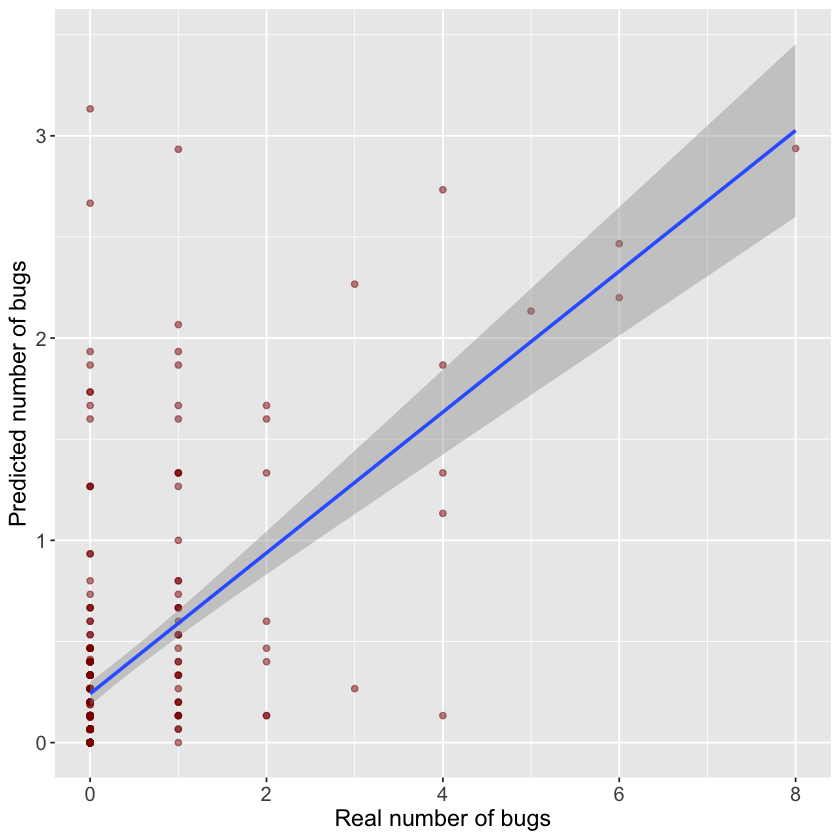

In [59]:
predictionChart(knnModel)

# kNN with Preprocessing

In [60]:
knnPreModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid,
  preProcess = c("center", "scale")
)

In [61]:
knnPreModel

k-Nearest Neighbors 

Pre-processing: centered (9), scaled (9) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.1070995  0.1423070  0.4221532
   3  0.9032730  0.2874003  0.3879289
   5  0.8403348  0.3248291  0.3643423
   7  0.8097836  0.3632999  0.3708973
   9  0.8128958  0.3692985  0.3758812
  11  0.8129340  0.3805914  0.3727066
  13  0.8224099  0.3707922  0.3784171
  15  0.8300455  0.3620683  0.3800055
  17  0.8347693  0.3587366  0.3851333
  19  0.8389089  0.3534071  0.3881110
  21  0.8392622  0.3577337  0.3881931
  23  0.8415520  0.3585299  0.3880573
  25  0.8411186  0.3652516  0.3892258

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 7.

In [62]:
knnPreModel$bestTune

,k
,<dbl>
4,7


In [63]:
knnPreStats <- evaluateStats(knnPreModel)
knnPreStats

$RMSE
[1] 0.715

$rSquare
[1] 0.476

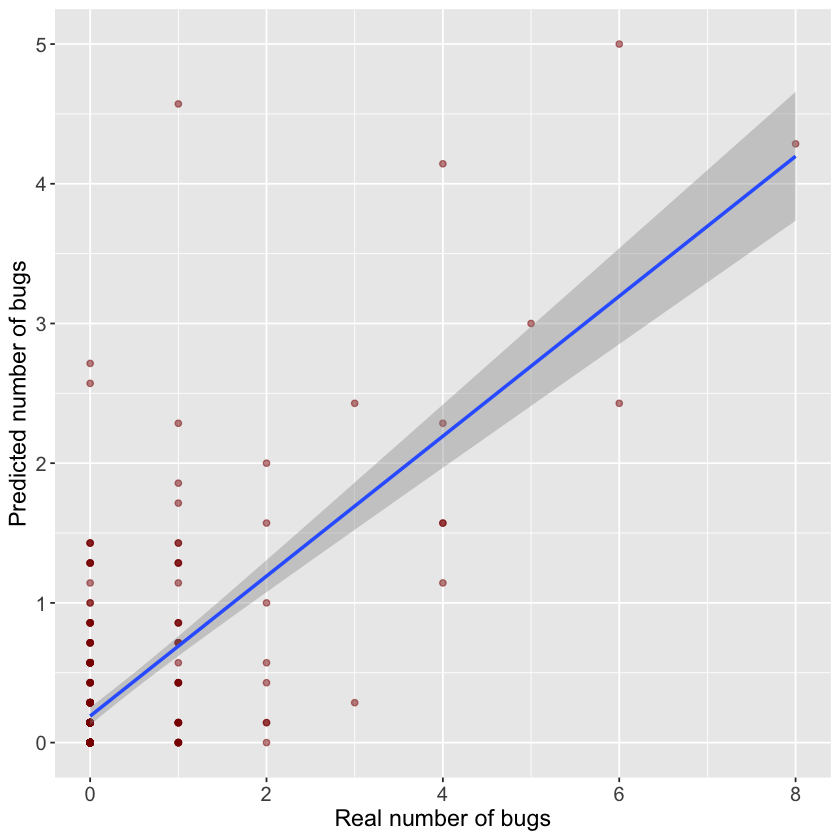

In [64]:
predictionChart(knnPreModel)

# Random Forest Regression

In [65]:
rfGrid <- expand.grid(.mtry=ncol(X_train)/3)

In [66]:
rfModel <- train(
  X_train, y_train,
  method = "rf",
  trControl = trcontrol,
  tuneGrid = rfGrid,
  importance = TRUE
)

In [67]:
rfModel

Random Forest 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 629, 628, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8619056  0.3481174  0.4241749

Tuning parameter 'mtry' was held constant at a value of 3

In [68]:
rfModel$bestTune

mtry
<dbl>
3


In [69]:
rfStats <- evaluateStats(rfModel)
rfStats

$RMSE
[1] 0.794

$rSquare
[1] 0.354

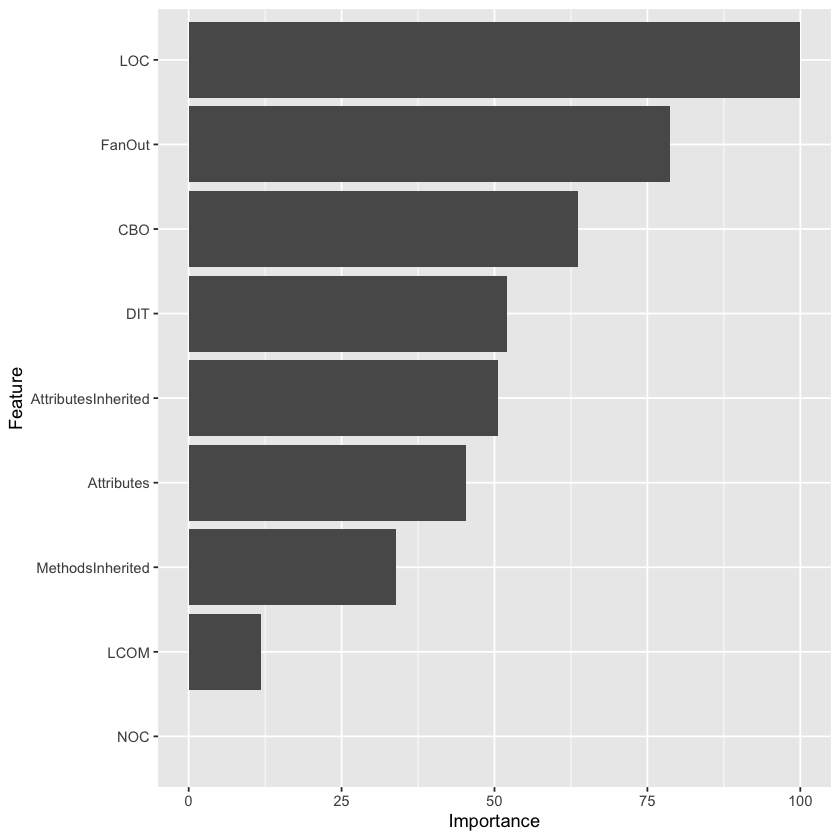

In [70]:
importancePlot(rfModel)

# Extreme Gradient Boosting regression

In [71]:
xgbGrid <- expand.grid(
    nrounds = c(100,200), 
    max_depth = c(10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    eta = 0.1,
    gamma=0,
    min_child_weight = 1,
    subsample = 1
  )

In [72]:
xgbModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

In [73]:
xgbModel

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.9204098  0.2600390  0.4482759
  10         0.5               200      0.9212335  0.2594297  0.4492838
  10         0.6               100      0.9200542  0.2712457  0.4367140
  10         0.6               200      0.9207382  0.2708256  0.4375386
  10         0.7               100      0.9324344  0.2833110  0.4436797
  10         0.7               200      0.9330991  0.2832967  0.4447132
  10         0.8               100      0.9568644  0.2476499  0.4461986
  10         0.8               200      0.9574800  0.2475869  0.4471682
  10         0.9               100      0.9926343  0.2328323  0.4567051
  10         0.9               200      0.9932483  0.2328073  0.4579999
  15         0.5 

In [74]:
xgbModel$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,100,20,0.1,0,0.5,1,1


In [75]:
xgbStats <- evaluateStats(xgbModel)
xgbStats

$RMSE
[1] 0.844

$rSquare
[1] 0.272

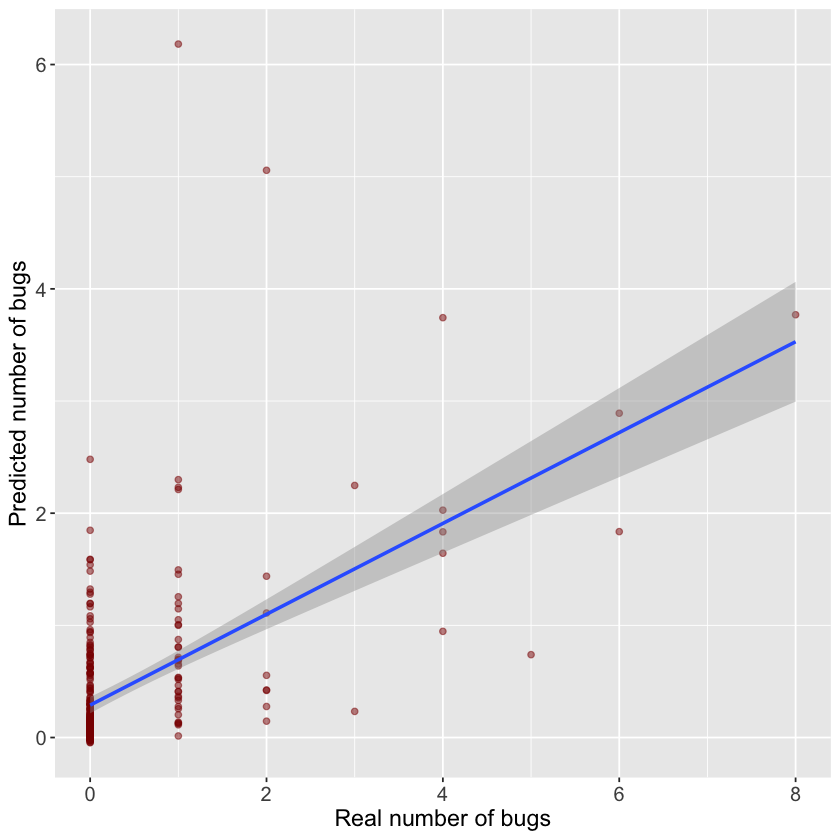

In [76]:
predictionChart(xgbModel)

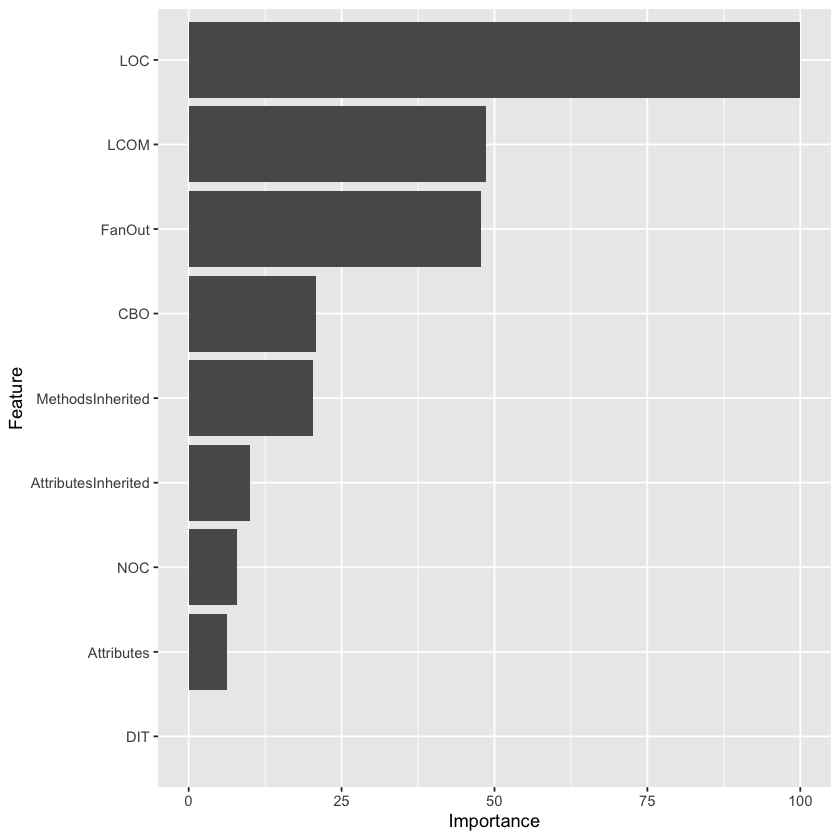

In [77]:
importancePlot(xgbModel)

In [78]:
xgbPreModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree",
  preProcess = c("center", "scale")
)

In [42]:
xgbPreModel

eXtreme Gradient Boosting 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8377464  0.4242739  0.4046140
  10         0.5               200      0.8381507  0.4242313  0.4049667
  10         0.6               100      0.8793881  0.3774892  0.4175277
  10         0.6               200      0.8796041  0.3775956  0.4175385
  10         0.7               100      0.8891448  0.3679789  0.4166799
  10         0.7               200      0.8894802  0.3680964  0.4169136
  10         0.8               100      0.9466178  0.3496045  0.4249864
  10         0.8               200      0.9470641  0.3499382  0.4254958
  10         0.9               100      0.9364910  0.3302226  0.4309303
  10         0.9               200      0.9367627  0.3307362  0

In [43]:
xgbPreModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [44]:
xgbPreStats <- evaluateStats(xgbPreModel)
xgbPreStats

$RMSE
[1] 0.796

$rSquare
[1] 0.169

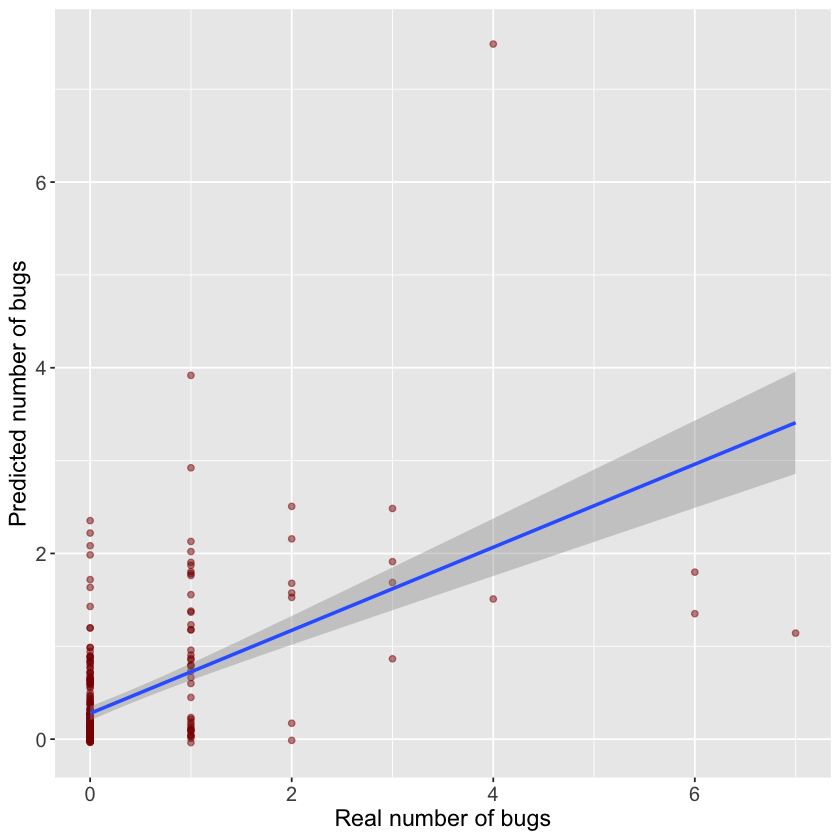

In [45]:
predictionChart(xgbPreModel)

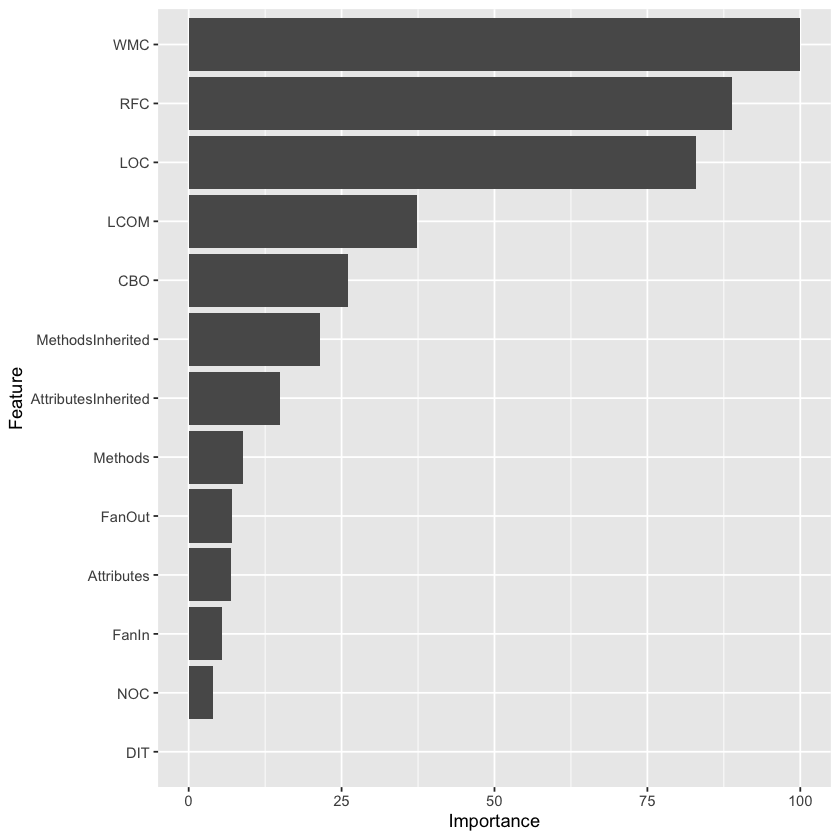

In [46]:
importancePlot(xgbPreModel)

# Neural Net predition using 'caret' library

In [47]:
nnetGrid <-  expand.grid(size = seq(from = 1, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 0.5, by = 0.1))

In [1]:
nnetModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid= nnetGrid,
  method = "nnet",
  preProcess = c("center", "scale")
)

ERROR: Error in train(X_train, y_train, trControl = trcontrol, tuneGrid = nnetGrid, : nie udało się znaleźć funkcji 'train'


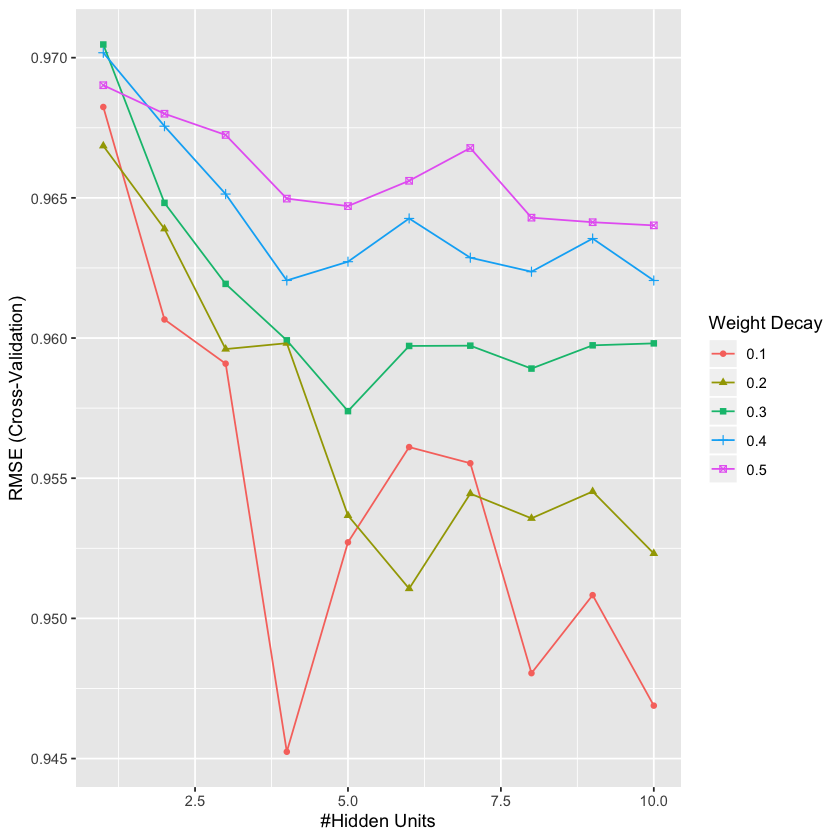

In [57]:
ggplot(nnetModel)

In [52]:
nnetModel$bestTune

,size,decay
,<dbl>,<dbl>
16,4,0.1


In [53]:
nnetModelStats <- evaluateStats(nnetModel)
nnetModelStats

$RMSE
[1] 0.752

$rSquare
[1] 0.258

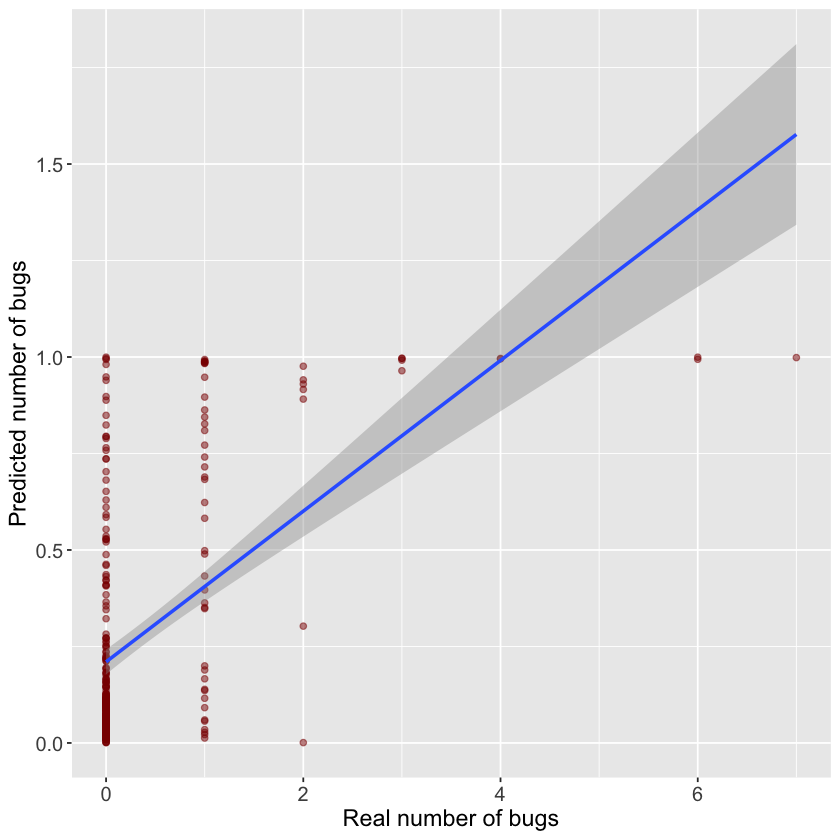

In [54]:
predictionChart(nnetModel)

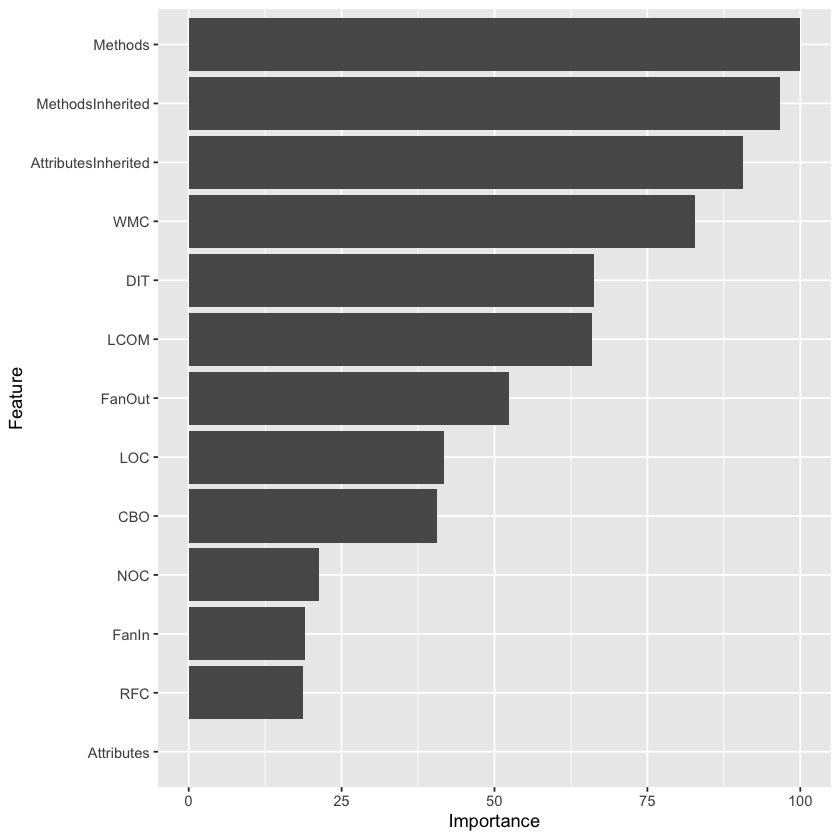

In [56]:
importancePlot(nnetModel)

# Neural Net predition using 'neuralnet' library

In [17]:
maxs <- apply(bugsData, 2, max) 
mins <- apply(bugsData, 2, min)
scaled <- as.data.frame(scale(bugsData, center = mins, scale = maxs - mins))
train_ <- scaled[inTrain,]
test_ <- scaled[-inTrain,]

In [18]:
n <- names(train_)
formula <- as.formula(paste("Bugs ~", paste(n[!n %in% "Bugs"], collapse = " + ")))
nnetModel2 <- neuralnet(formula,data=train_,hidden=c(4,3,2), algorithm="rprop+", linear.output=TRUE)

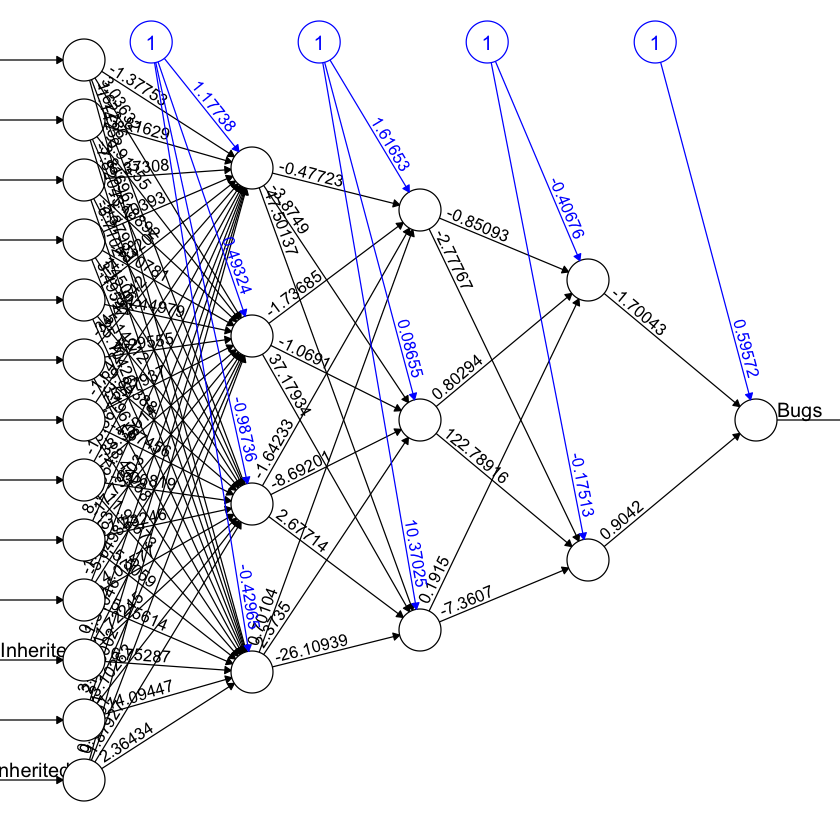

In [19]:
plot(nnetModel2, rep="best")

In [22]:
nnetModel2Stats <- evaluateStats(nnetModel2)
nnetModel2Stats

$RMSE
[1] 0.888

$rSquare
[1] -0.035

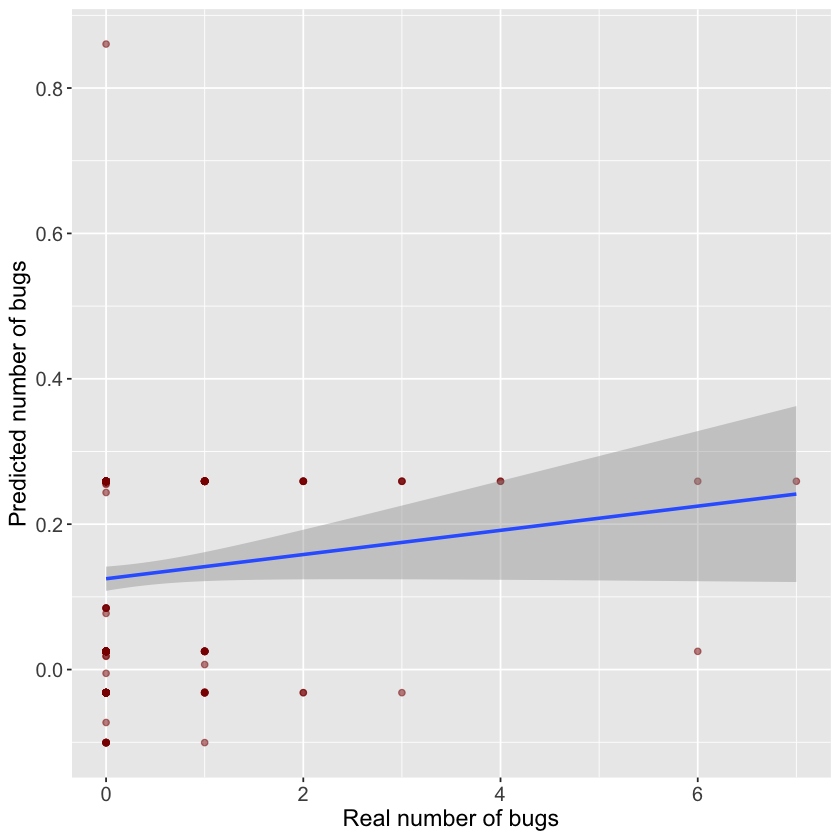

In [25]:
predictionChart(nnetModel2)

ERROR: Error in UseMethod("varImp"): niestosowalna metoda dla 'varImp' zastosowana do obiektu klasy "nn"


To be continued... Just some experiments.

# TODO Compare different regression models

In [21]:
compareDf <- data.frame(t(data.frame(
    knn = unlist(knnStats),
    knnPre = unlist(knnPreStats),
    rf = unlist(rfStats),
    xgb = unlist(xgbStats),
    xgbPre = unlist(xgbPreStats),
    nnetCaret = unlist(nnetModelStats),
    nnetNeuralnet = unlist(nnetModel2Stats)
)))
compareDf

ERROR: Error in unlist(knnStats): nie znaleziono obiektu 'knnStats'


To be continued...